# N-gram Lanuage Models

### Introduction

Our goal is to build a machine that assigns probabilities to words or sequences of words. We call such machine *language model*.

The probability model is over the set of all finite sequences over a given vocabulary (aka alphabet) $\mathcal W$, which is assumed to be finite.  


- Goal: compute the **probability** of a sequence $w^n = (w_1,\ldots,w_n)$ of tokens:
$$
\Pr[W^n=w^n] = \Pr[W_1=w_1,W_2=w_2,W_3= w_3,W_4 = w_4,\ldots,W_n = w_n]
$$
or the **probability** of an upcoming token:
$$
\Pr[w_5|w_1,w_2,w_3,w_4] = \Pr[w_5|w^4]
$$
- A model that computes either of these is called a **language model** (LM)

How to compute 
$$
\begin{align*}
& \Pr[\text{its}, \text{water}, \text{is}, \text{so}, \text{transparent}, \text{that}] \\
& = \Pr[W_1=\text{its}, W_2=\text{water}, W_3=\text{is}, W_4=\text{so}, W_5=\text{transparent}, W_6=\text{that}] 
\end{align*}
$$
- Use the **chain rule** of joint probabilities:
$$
\begin{align*}
\Pr[w^6] & = \Pr[W_1 = \text{its}] \\&  \times \Pr[W_2 = \text{water}|W_1 = \text{its}] \\
& \times  \Pr[W_3=\text{is}|W^{2} = \text{its water}] \\
& \times  \Pr[W_4=\text{so}|W^3 = \text{its water is}] \\
& \times  \Pr[W_5=\text{transparent}|W^4 = \text{its water is so}]  \\
& \times  \Pr[W_6=\text{that}|W^5 = \text{its water is so transparent}] 
\end{align*}
$$


## How to estimate these probabilities?
- Could we just count and divide:
$$
\Pr[\text{the} | \text{its water is so transparent that} ] = \frac{N(\text{its water is so transparent that the})}{N(\text{its water is so transparent that}) }
$$
Generally, no! too many possibilities; see Google N-gram release https://blog.research.google/2006/08/all-our-n-gram-are-belong-to-you.html

- We need a simplified model. One example is a Markov model:
$$
\Pr[\text{the} | \text{its water is so transparent that} ] \approx \Pr[\text{the} | \text{that} ]
$$
or 
$$
\Pr[\text{the} | \text{its water is so transparent that} ] \approx \Pr[\text{the} | \text{transparent that} ]
$$
- Under $k$-order Markov Model:
$$
\Pr[w^n] = \Pr[w_1w_2\cdots w_n] \approx \prod_{i=1}^n \Pr[w_i|w_{i-{k}} \cdots w_{i-1}]
$$
(we approximate each component in the product)


### General Language Modeling
- In general, we can propose a model parameterized by some $\theta \in \reals^N$
$$
    \Pr[\cdot|w^{n-1}] = f_{\theta}(w^{n-1}),\qquad \theta \in \reals^N
$$
and learn $\theta$ from the data.

For example: 
- $f_{\theta}$ is multi-head attention transformer neural network
- $\theta$ are the attention parameters
- Learning is achieved via gradient descent with the crossentropy loss (logloss) function 

### N-gram Model

An N-gram model makes the $k = N-1$ Markov assumption:
$$
\begin{align*}
\Pr[w^n] & = \Pr[w_1,w_2,w_3,\ldots,w_n] \\
& = \prod_{i=1}^n \Pr[w_i | w_{i-N+1},\ldots,w_{i-1}] \\
& = \prod_{i=1}^n \Pr[w_i | w^{i-1}_{i-N+1}] 
\end{align*}
$$
where:
$$ 
w^{m+p}_{m} := \begin{cases} (w_m,\ldots,w_{m+p}) & m \geq 1, \\
\emptyset & p\leq 0,
\end{cases}
$$
for $m=1,2,\ldots$, $p \in \mathbb Z$.

For example, with $N=2$ we have:
$$
\Pr[w_1,w_2,w_3,\ldots,w_n] =  \Pr[w_1]\prod_{i=2}^n \Pr[w_i | w_{i-1}] 
$$


An N-gram language model has $~|\mathcal W|^N$ parameters (enough to represent the joint distribution of all $N$ consecutive tokens)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import re

## Building N-gram models

### Large Movie Review Dataset

Link to download class version: https://cloud.cs.idc.ac.il/index.php/s/ScL9qfw3zTHy8x8

Original dataset is from https://ai.stanford.edu/~amaas/data/sentiment/: This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well. Raw text and already processed bag of words formats are provided. See the README file contained in the release for more details.

(direct link https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz)

Here we use this dataset arranged in a .csv file as an be found at https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?resource=download


Read dataset file. Each row is a review. 

In [85]:
DATA_FOLDER = "./"
df = pd.read_csv(DATA_FOLDER + "IMDB reviews.csv")
print(df.describe())
print(df.head())

                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


####  Add sentence start and end symbols:

In [3]:
import re

SENT_START_TOKEN = '<s>'
SENT_END_TOKEN = '</s>'

def split_to_sentences(text: str, sep=r'\.|\n') -> str:
    """
    Add SENT_START_TOKEN and SENT_END_TOKEN at the beginning and
    ending of every sentence. 
    
    Args:
        :text: is a text input
        :sep: explains how to identify sentnce ending (regular expression)
    """
    return re.split(sep, text)

def add_sentence_break_symbols(sentences: list) -> str:
    sent_break = f' {SENT_END_TOKEN} {SENT_START_TOKEN} '
    return SENT_START_TOKEN + ' ' + sent_break.join(sentences) + ' ' + SENT_END_TOKEN

df['review_sb'] = df['review'].apply(split_to_sentences).apply(add_sentence_break_symbols)

In [4]:
print(df.head())

                                              review sentiment  \
0  One of the other reviewers has mentioned that ...  positive   
1  A wonderful little production. <br /><br />The...  positive   
2  I thought this was a wonderful way to spend ti...  positive   
3  Basically there's a family where a little boy ...  negative   
4  Petter Mattei's "Love in the Time of Money" is...  positive   

                                           review_sb  
0  <s> One of the other reviewers has mentioned t...  
1  <s> A wonderful little production </s> <s>  <b...  
2  <s> I thought this was a wonderful way to spen...  
3  <s> Basically there's a family where a little ...  
4  <s> Petter Mattei's "Love in the Time of Money...  


### Unigram Model:
$$
\Pr[w^n] = \prod_{i=1}^n \Pr[w_i] 
$$
(assign probability to sentences based on frequency of occurances of words regardless of neighboring words or their location in the sentence).


We first list all words. We ignore capitalization, numbers, punctuations and white spaces. We use this 'cleaning' process for simplicity, but it is not always a good idea and we may not do the same for more sophisticated models.

In [5]:
TOKEN_PATTERN = r"(?u)\b[a-zA-Z]+\b|\</?s\>"

tokens = []
for sent in tqdm(df['review_sb']):
    tokens += re.findall(TOKEN_PATTERN, sent.lower())

  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [00:02<00:00, 23321.82it/s]


(you can get yourself familiar with regular expressions at https://www.regular-expressions.info/)

The next line actualy does the counting; it uses ``value_counts`` method of ``pandas``

In [6]:
df_counts = pd.DataFrame(pd.DataFrame(tokens).value_counts())\
                .rename(columns = {0 : 'count'})

df_counts.loc[:, 'freq'] = df_counts['count'] / df_counts['count'].sum()
model_1gram = df_counts

In [7]:
model_1gram.head(15)

,count,freq
0,,
</s>,700520,0.052692
<s>,700520,0.052692
the,667993,0.050246
and,324441,0.024404
a,322970,0.024294
of,289410,0.021769
to,268124,0.020168
is,211082,0.015877
br,201951,0.015191


We see that the two special symbols are also most frequent. These symbols are not informative in a unigram model hence we remove them:

In [8]:
model_1gram = model_1gram.drop(['</s>', '<s>'])   # remove symbols
model_1gram['freq'] = model_1gram['count'] / model_1gram['count'].sum()  # re-calculate frequencies

/var/folders/3n/c1thdb3136qc3c_4t5br9r6c0000gq/T/ipykernel_94935/1433239876.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  model_1gram = model_1gram.drop(['</s>', '<s>'])   # remove symbols


In [9]:
model_1gram.head(15)

,count,freq
0,,
the,667993,0.056165
and,324441,0.027279
a,322970,0.027155
of,289410,0.024334
to,268124,0.022544
is,211082,0.017748
br,201951,0.016980
it,190857,0.016047
in,186781,0.015705


Illustrating "Zipf law" $f_i \propto 1/i$ for uniframs. Zipf "law" is a phenomena discovered by American linguist George Kingsley Zipf
https://en.wikipedia.org/wiki/George_Kingsley_Zipf

The Zipf phenomena only occurs in the most frequent words, after which the tail become thiner than $1/i$ (converges to zero faster) 

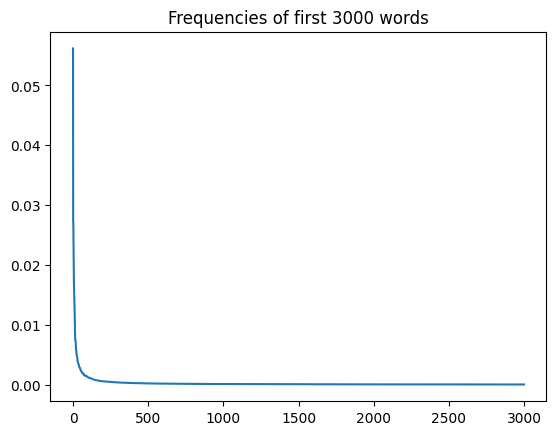

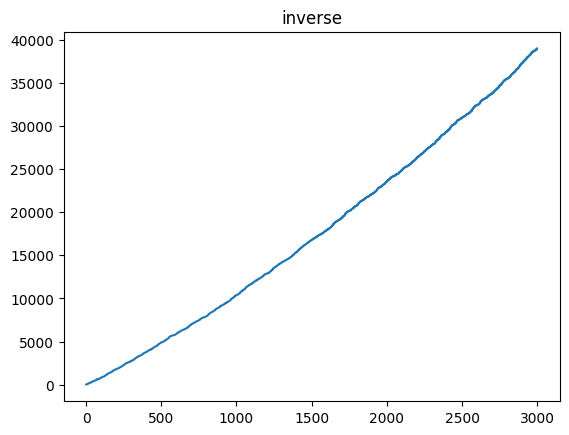

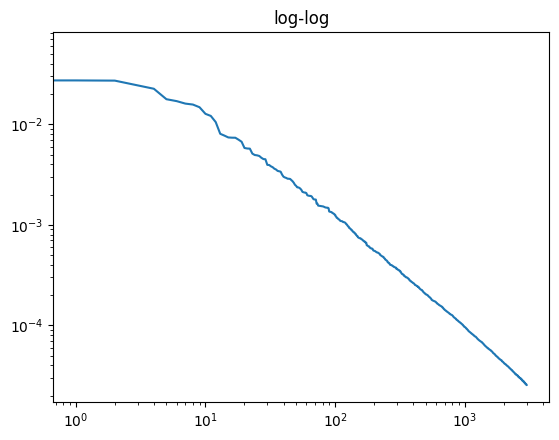

In [10]:
n = 3000
plt.title(f"Frequencies of first {n} words")
plt.plot(model_1gram.freq.values[:n])
plt.show()

plt.title("inverse")
plt.plot(1 / model_1gram.freq.values[:n])
plt.show()

plt.title("log-log")
plt.loglog(model_1gram.freq.values[:n])
plt.show()

The entire procedure is summarized as follows

In [11]:
from nltk import ngrams
TOKEN_PATTERN = r"(?u)\b[a-zA-Z]+\b|\</?s\>"
SENT_START_TOKEN = '<s>'
SENT_END_TOKEN = '</s>'


def is_sublist(list_a: list, list_b: list)-> bool:
    """
    Is list_a a sublist of list_b?
    """
    return str(list_a).strip('[').strip(']') in str(list_b)


def ng_tokenize(text: str, ng: int) -> list:
    """
    extract ngram and add sepcial symbols
    
    Args:
      :text:  text
      :ng:    ngram level
      
    Returns:
      list of ngrams 
    """
    tokens = re.findall(TOKEN_PATTERN, text.lower())
    ngz = ngrams(tokens, ng,
                 pad_left=True, pad_right=True,
                 left_pad_symbol=SENT_START_TOKEN,
                 right_pad_symbol=SENT_END_TOKEN)
    return list(ngz)


def clean_text(text: str) -> str:
    """
    clean text 
    """    
    text = text.lower()
    text = re.sub(r"<br ?/>", " ", text)  # replace '<br />' with ' '
    text = re.sub(r"\.\.+", " ", text)  # replace '..' or a longer sequence with ' '
    
    return text


def build_ngram_model(text: str, ng: int) -> pd.DataFrame:
    """
    1. Clean text
    2. Add sentence begin and end symbols
    3. Extract ngrams
    4. Remove unwanted tokens
    5. Compute frequency of every token
    
    Returns:
      dataframe. Indexes are ngrams. Columns indiacte number of occurances 
      and frequency of occurance
    """
    print("Cleaning text...")
    text = clean_text(text)
    print("Breaking to sentences")
    sentences = split_to_sentences(text)
    print("Extracting tokens...")
    tokens = []
    for sent in tqdm(sentences):
        tokens += ng_tokenize(sent, ng)
    print("Removing unacceptable tokens...")
    tokens = [t for t in tokens if not 
              (('<s>' in t[1:]) or ('</s>' in t[:-1]) or (is_sublist(["<s>", "</s>"], t)))]
    print("Counting tokens...")
    df_ng = pd.DataFrame(pd.DataFrame(tokens).value_counts()).rename(columns = {0 : 'count'})
    print("Computing frequencies...")
    df_ng.loc[:, 'freq'] = df_ng['count'] / df_ng['count'].sum()  # compute frequencies
    return df_ng

### Bigram Model:
$$
\Pr[w_1,w_2,w_3,\ldots,w_n] = \prod_{i=1}^n \Pr[w_i|w_{i-1}] 
$$
(assign probability to sentences based on frequency of occurances of a word given the previous word in the sentence).


In [12]:
model_2gram = build_ngram_model(" ".join(df.review), 2)

Cleaning text...
Breaking to sentences
Extracting tokens...


100%|██████████| 564901/564901 [00:03<00:00, 143658.17it/s]


Removing unacceptable tokens...
Counting tokens...
Computing frequencies...


In [13]:
k = 15
print(f" {k} most frequenct bigrams:")
model_2gram

 15 most frequenct bigrams:


count          freq
0                                            1                           
of                                           the      77275  6.306123e-03
<s>                                          the      70588  5.760422e-03
                                             i        55533  4.531840e-03
in                                           the      50275  4.102754e-03
it                                           s        33762  2.755190e-03
...                                                     ...           ...
help                                         kill         1  8.160625e-08
                                             kidman       1  8.160625e-08
                                             kidd         1  8.160625e-08
                                             keitaro      1  8.160625e-08
zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz </s>         1  8.160625e-08

[2117313 rows x 2 columns]

Bigrams also obey the Zipf law:

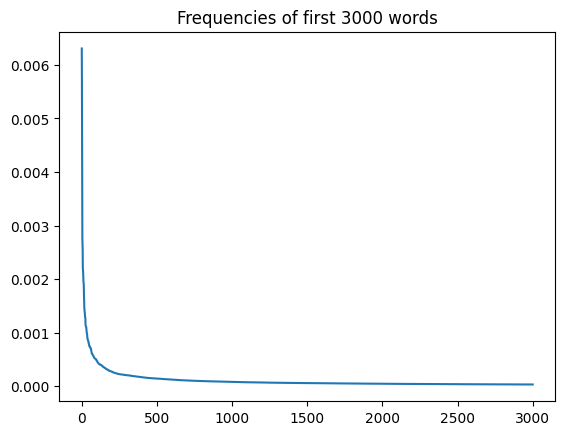

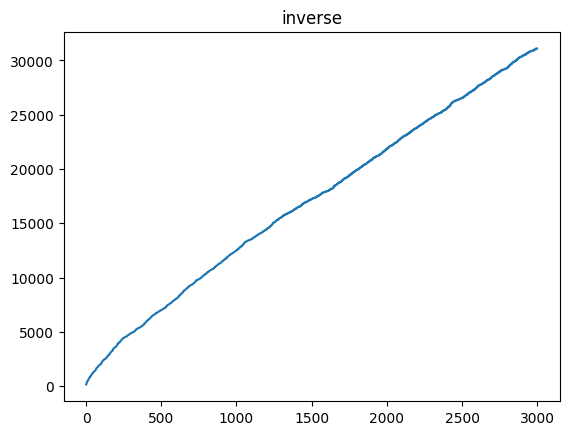

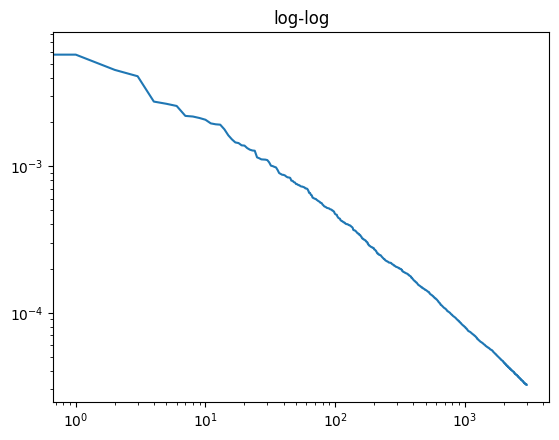

In [14]:
n = 3000

plt.title(f"Frequencies of first {n} words")
plt.plot(model_2gram.freq.values[:n])
plt.show()

plt.title("inverse")
plt.plot(1 / model_2gram.freq.values[:n])
plt.show()

plt.title("log-log")
plt.loglog(model_2gram.freq.values[:n])
plt.show()

### Trigram Model

$$
\Pr[w_1,w_2,w_3,\ldots,w_n] = \prod_{i=1}^n \Pr[w_i|w_{i-1},w_{i-2}] 
$$


In [15]:
model_3gram = build_ngram_model(" ".join(df.review), ng=3)

Cleaning text...
Breaking to sentences
Extracting tokens...


100%|██████████| 564901/564901 [00:03<00:00, 171520.44it/s]


Removing unacceptable tokens...
Counting tokens...
Computing frequencies...


In [16]:
k = 15
print(f"{k} most frequent 3grams:")
print(model_3gram.head(k))

15 most frequent 3grams:
                  count      freq
0    1     2                     
<s>  it    s      10596  0.000906
one  of    the     9824  0.000840
<s>  this  is      7837  0.000670
     it    is      5728  0.000490
     if    you     5523  0.000472
i    don   t       5421  0.000464
this movie is      5277  0.000451
of   the   film    5173  0.000442
<s>  this  movie   5120  0.000438
this is    a       4817  0.000412
it   s     a       4703  0.000402
a    lot   of      4694  0.000401
of   the   movie   4330  0.000370
<s>  the   film    4227  0.000362
this movie </s>    4114  0.000352


# Sentence probability


In [17]:
class State(object):
    """
    class to manage sequential state progression
    
    Args:
        past, present, future are lists
        
    Methods:
        State::step   update one step in time, so that the present 
        is appended to the past and the present gets the next value from the future
    """
    def __init__(self, past: list, present: list, future: list):
        self.past = past
        self.present = present
        self.future = future
        
    def step(self):
        self.past += self.present
        if len(self.future) > 0:
            self.present = [self.future.pop(0)]
        else:
            self.present = []
            self.future = []
            
    def print_state(self):
        print("past:", self.past)
        print("present:", self.present)
        print("future:", self.future)


In [18]:

def token_probability(token : str, model: pd.DataFrame) -> float:
    """
    probability of a token under the model
    
    Notes: 
    1. Returns the marginal probability if the token is smaller than the size of the model
    2. Returns 1 if token == "" or token == [].
    """
    
    if len(token) == 0:  
        return 1     # we agree that an empty token has probability 1
    token_idx = tuple(token)
    
    if token_idx in model.index:
        return model.loc[token_idx].freq.sum()  # the sum is to allow marginalization if
                                                # the token is smaller than an n-gram
    # else:
    print(f"Unrecognized Token '{token}'")
    raise ValueError                
    

def conditional_probability(token_a: list, token_b: list, model: pd.DataFrame, verbose=False) -> float:
    """
    Probability of token_a given token_b under the model
    (token can contain multiple words depending on the model definition)
    """
    
    pr_b = token_probability(token_b, model)
    pr_ab = token_probability(token_b + token_a, model)
    return pr_ab / pr_b
    
    
def sentence_probability(sent: str, model: pd.DataFrame,
                         verbose=False, backoff=False) -> float:
    """
    Probability of a sentence under an n-gram languge model
    
    Args:
        :sent:    the sentence 
        :model:   the model
        :verbose: flag whther to print computing process
        :bakcoff: try backing off to handle unknown ngrams
        
    Returns:
       probability
    """
    
    ng = len(model.index[0])  # identify model order

    sent_atoms = sent.split()  
    first_token = sent_atoms[:1] 

    word_stream = State(past=[], present=first_token, future=sent_atoms[1:])

    # update state
    logprob = 0
    while len(word_stream.present) > 0:
        if backoff:
            pr_token = conditional_probability_backoff(word_stream.present,
                                                       word_stream.past[-ng+1:],
                                                       model, verbose=verbose)
        else:
            pr_token = conditional_probability(word_stream.present, word_stream.past[-ng+1:],
                                               model)
        logprob += np.log(pr_token)
        if verbose:
            word_stream.print_state()
            print(f"P(present|past) = {pr_token}")
            print("------------------------------------")
        word_stream.step()

    return np.exp(logprob)


def conditional_probability_backoff(token_a:str, token_b:str, model: pd.DataFrame, verbose=False) -> float:
    """
    same as `conditional_probability`, but backs off if n-gram token_a + token_b 
    is not recognized by the model. 
    
     """
    
    joint_token_idx = tuple(token_b + token_a)
        
    if (joint_token_idx not in model.index) and (token_b != []):
        if verbose:
            print(f"Token_a = {token_a}, Backing-off from {token_b} to {token_b[1:]}...")
        
        return conditional_probability_backoff(token_a, token_b[1:], model)
    
    return conditional_probability(token_a, token_b, model)
   


Make sure that conditional probability behaves as expected:

In [19]:
import warnings

warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

test_tokens = ['<s>', 'on', 'of', 'there', 'movie']
for t in test_tokens:
    assert conditional_probability([t],[], model_2gram) == token_probability([t], model_2gram)

### Probability of a bigram:

In [20]:
print(conditional_probability(['of'], ['one'], model_2gram)) #* token_probability('one', model_2gram))
print()
print(sentence_probability("one of", model_2gram))
print(sentence_probability("<s> one of", model_2gram))
print(sentence_probability("one of </s>", model_2gram))
print(sentence_probability("<s> one of </s>", model_2gram))

0.303154674178684

0.0013261014966259083
9.250029841397449e-05
7.894934102783051e-06
5.506997483406865e-07


In [21]:
print(sentence_probability("<s> one of the", model_2gram))
print(sentence_probability("<s> one of the best", model_2gram))
print(sentence_probability("<s> one of the best performance", model_2gram))

2.4698388307038047e-05
2.6029711940326926e-07
4.643740236737678e-09


Discuss the differences

#### Probability of a longer sentence:

##### Bigram model:
As opposed to what was said in class, the probability calculation below of the first two token is correct. The part that is incorrect or meaningless is the printout: P(present|past) in the first token. Indeed, one can verify that as follows:

In [22]:
print(sentence_probability("<s> one of", model_3gram, verbose=True))

past: []
present: ['<s>']
future: ['one', 'of']
P(present|past) = 0.04810834875407402
------------------------------------
past: ['<s>']
present: ['one']
future: ['of']
P(present|past) = 0.006647595646971601
------------------------------------
past: ['<s>', 'one']
present: ['of']
future: []
P(present|past) = 0.3452794864937148
------------------------------------
0.0001104220543035305


In [23]:
print("<s> one ", token_probability(["<s>", "one"], model_2gram))
print("one of  ", token_probability(["one", "of"], model_2gram))

<s> one  0.0003051257535928782
one of   0.0013261014966259083


In [24]:
print(sentence_probability("<s> no one expects the star trek movies to be high art </s>", model_3gram, verbose=True))

past: []
present: ['<s>']
future: ['no', 'one', 'expects', 'the', 'star', 'trek', 'movies', 'to', 'be', 'high', 'art', '</s>']
P(present|past) = 0.04810834875407402
------------------------------------
past: ['<s>']
present: ['no']
future: ['one', 'expects', 'the', 'star', 'trek', 'movies', 'to', 'be', 'high', 'art', '</s>']
P(present|past) = 0.004055406705199845
------------------------------------
past: ['<s>', 'no']
present: ['one']
future: ['expects', 'the', 'star', 'trek', 'movies', 'to', 'be', 'high', 'art', '</s>']
P(present|past) = 0.1297676457693994
------------------------------------
past: ['<s>', 'no', 'one']
present: ['expects']
future: ['the', 'star', 'trek', 'movies', 'to', 'be', 'high', 'art', '</s>']
P(present|past) = 0.0033500837520938015
------------------------------------
past: ['<s>', 'no', 'one', 'expects']
present: ['the']
future: ['star', 'trek', 'movies', 'to', 'be', 'high', 'art', '</s>']
P(present|past) = 0.15624999999999994
---------------------------------

##### Trigram model

In [25]:
sentence_probability("<s> what", model_3gram, verbose=True)

past: []
present: ['<s>']
future: ['what']
P(present|past) = 0.04810834875407402
------------------------------------
past: ['<s>']
present: ['what']
future: []
P(present|past) = 0.008789974024773356
------------------------------------


0.0004228711359230482

In [26]:
token_probability(['<s>', 'what'], model_3gram)

0.0004228711359230483

In [27]:
print(sentence_probability("<s> no one expects the star trek movies to be high art </s>", model_3gram, verbose=True))

past: []
present: ['<s>']
future: ['no', 'one', 'expects', 'the', 'star', 'trek', 'movies', 'to', 'be', 'high', 'art', '</s>']
P(present|past) = 0.04810834875407402
------------------------------------
past: ['<s>']
present: ['no']
future: ['one', 'expects', 'the', 'star', 'trek', 'movies', 'to', 'be', 'high', 'art', '</s>']
P(present|past) = 0.004055406705199845
------------------------------------
past: ['<s>', 'no']
present: ['one']
future: ['expects', 'the', 'star', 'trek', 'movies', 'to', 'be', 'high', 'art', '</s>']
P(present|past) = 0.1297676457693994
------------------------------------
past: ['<s>', 'no', 'one']
present: ['expects']
future: ['the', 'star', 'trek', 'movies', 'to', 'be', 'high', 'art', '</s>']
P(present|past) = 0.0033500837520938015
------------------------------------
past: ['<s>', 'no', 'one', 'expects']
present: ['the']
future: ['star', 'trek', 'movies', 'to', 'be', 'high', 'art', '</s>']
P(present|past) = 0.15624999999999994
---------------------------------

Trigram probability is generally higher for "natural" sentences

In [28]:
print(sentence_probability("<s> one expects the star trek movies to be okay", model_3gram))

7.954344078841356e-18


In [29]:
print(sentence_probability("<s> one expects the star trek movies to be fair", model_3gram))

2.883449728580011e-16


In [30]:
sent = "<s> a wonderful little production </s>"
print(f"2gram probability of '{sent}': p = ", sentence_probability(sent, model_2gram))
print(f"3gram probability of '{sent}': p = ", sentence_probability(sent, model_3gram))

2gram probability of '<s> a wonderful little production </s>': p =  7.83138402611925e-13
3gram probability of '<s> a wonderful little production </s>': p =  6.345117780912522e-10


In general, the 3-gram model gives higher probabilities to more English looking sentences

### What kinds of knowledge we can get from a model?

In [31]:
model = model_3gram
print("actor vs. actress")
print("=================")

for w in ['good', 'great', 'talented', 'poor']:
    print(w)
    p1 = conditional_probability(['actor'], [w.lower()], model)
    p2 = conditional_probability(['actress'], [w.lower()], model)
    print("\t","actor: ", p1)
    print("\t","actress: ", p2)
    print("\t","actor/actress ratio: ", p1 / p2)


actor vs. actress
good
	 actor:  0.006738692547152538
	 actress:  0.003296099615455045
	 actor/actress ratio:  2.044444444444445
great
	 actor:  0.011464819880114068
	 actress:  0.004655764418320434
	 actor/actress ratio:  2.4625
talented
	 actor:  0.04549590536851683
	 actress:  0.03366696997270246
	 actor/actress ratio:  1.3513513513513513
poor
	 actor:  0.001943904470980283
	 actress:  0.0005554012774229379
	 actor/actress ratio:  3.500000000000001


Gramer correction:

In [32]:
model = model_3gram
print(sentence_probability("one of the best action movies </s>", model))
print(sentence_probability("one of the best action movie </s>", model))

3.7215893357787573e-09
2.1854113201173367e-09


In [33]:
model = model_2gram
print(sentence_probability("talking at her", model))
print(sentence_probability("talking with her", model))
print(sentence_probability("talking to her", model))

5.7194121090505905e-09
6.281872613389775e-08
1.1115748059008867e-07


Movies are more likely to be watched than read:

In [34]:
print(sentence_probability("<s> only one movie to read </s>", model_3gram))
print(sentence_probability("<s> only one movie to watch </s>", model_3gram))

5.005703106712864e-15
5.081338926216576e-12


### The method breaks when we ask for unseen ngrams:

In [35]:
print(sentence_probability("<s> a great movie to bake at home </s>", model_3gram))

Unrecognized Token '['movie', 'to', 'bake']'


ValueError: 

One solution is "simple backoff":
$$
\Pr[w_i|w_{i-N+1}^{i-1}] \approx \Pr[w_i|w_{i-k+2}^{i-1}]
$$
(removing words from the tail of the conditioned sentence)

In [ ]:
print(sentence_probability("<s> a great movie to bake at home </s>", model_3gram, backoff=True, verbose=True))

past: []
present: ['<s>']
future: ['a', 'great', 'movie', 'to', 'bake', 'at', 'home', '</s>']
P(present|past) = 0.04810834875407402
------------------------------------
past: ['<s>']
present: ['a']
future: ['great', 'movie', 'to', 'bake', 'at', 'home', '</s>']
P(present|past) = 0.01580559649681132
------------------------------------
past: ['<s>', 'a']
present: ['great']
future: ['movie', 'to', 'bake', 'at', 'home', '</s>']
P(present|past) = 0.025084364454443193
------------------------------------
past: ['<s>', 'a', 'great']
present: ['movie']
future: ['to', 'bake', 'at', 'home', '</s>']
P(present|past) = 0.09749626927541037
------------------------------------
past: ['<s>', 'a', 'great', 'movie']
present: ['to']
future: ['bake', 'at', 'home', '</s>']
P(present|past) = 0.0599250936329588
------------------------------------
Token_a = ['bake'], Backing-off from ['movie', 'to'] to ['to']...
past: ['<s>', 'a', 'great', 'movie', 'to']
present: ['bake']
future: ['at', 'home', '</s>']
P(pre

Note that with "simple backoff" we no longer have a probability distribution interpertation. 

Other techniques to handle zeros: See [Jurafsky & Martin] for details. 

## logloss/log-perplexity/Empirical Entropy

### Log logloss of sequence $w^n=(w_1,\ldots,w_n)$ under model P:
$$
logloss(w^n,P) = - \frac{1}{n} \log(\Pr[w^n]) = - \frac{1}{n} \sum_{i=1}^n \log(\Pr[w_i|w^{i-1}_{i-N+1}]) 
$$

In [ ]:
def logloss(sentence: str, model: pd.DataFrame) -> float:
    """
    evalaute the logloss of `sentence` under the model
    """
    N = len(sentence.split())
    prob = sentence_probability(sentence, model, backoff=True)
    return -np.log(prob) / N
        

Logloss of a single sentence:

In [ ]:
sentences = ["<s> not as good as your average movie but still does the trick </s>",
             "<s> great do me but soon get out </s>"]

for sent in sentences:
    print("Sentence: ", sent)
    print(f"Logloss of bigram model = {logloss(sent, model_2gram)}")
    print(f"Logloss of trigram model = {logloss(sent, model_3gram)}")
    print()

Sentence:  <s> not as good as your average movie but still does the trick </s>
Logloss of bigram model = 4.60081664621313
Logloss of trigram model = 3.645750498744358

Sentence:  <s> great do me but soon get out </s>
Logloss of bigram model = 5.580155663436397
Logloss of trigram model = 5.353465224792829



Logloss of many sentences

In [ ]:
import re


def preprocess_sentence(text: str) -> str:
    """
    clean text according to tokenizer and  
    add sybols indicating beginning and ending
    """
    return  '<s> ' + " ".join(re.findall(TOKEN_PATTERN, text)).lower() + ' </s>'


def to_sentences(text: str) -> list:
    """
    Convert text after preprocessing to a list 
    of sentences
    """
    text = clean_text(text)
    sentences = split_to_sentences(text)
    return [preprocess_sentence(sent) for sent in sentences if len(sent.split()) > 2]



In [125]:
model = model_2gram

N = 10
test_set = df.sample(N).review.apply(clean_text)

ls = []
for doc in tqdm(test_set):
    for sent in to_sentences(doc):
        try:
            ll = logloss(sent, model)
            if ll > 0:
                ls += [ll]
        except:
            print("Cound not evaluate logloss of sent: ", sent)
print(f"Average logloss of bigram model over {N} samples: {np.mean(ls)}, (std = {np.std(ls)})")


  2%|▏         | 2/100 [00:07<05:51,  3.59s/it]

Cound not evaluate logloss of sent:  <s> for years i did not know the name but the movie stuck in my mind </s>


  3%|▎         | 3/100 [00:09<04:27,  2.76s/it]/var/folders/3n/c1thdb3136qc3c_4t5br9r6c0000gq/T/ipykernel_77011/1625853032.py:7: RuntimeWarning: divide by zero encountered in log
  return -np.log(prob) / N
  8%|▊         | 8/100 [00:21<03:40,  2.40s/it]

## Sampling from the model
generate random sentences according to model's probability

In [36]:
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

def sample_from_model(ngram_model, prompt=['<s>']):
    
    def sample_from_list(df):
        return df.sample(n=1, weights = df.freq)
    
    w = ''
    state = prompt
    smp = sample_from_list(ngram_model.loc[state])
    state = list(smp.index[0][1:])
    w = list(state)
    while w[-1] != '</s>': 
        df_pool = ngram_model.loc[tuple(state)]
        smp = df_pool.sample(n=1, weights = df_pool.freq)
        state = state[1:] + [smp.index[0]]
        w.append(state[-1])
    return w[:-1] + ['</s>']

In [42]:
prompt = ['<s>']
for _ in range(5):
    print(" ".join(prompt + sample_from_model(model_3gram, prompt=prompt)))

<s> if a co incidence </s>
<s> eventually the mistake of missing car keys that seem to have their first sortie together and forced to appear nude in a supermarket manager and thank goodness then for the humor in this film the hero fighting against a backdrop to what really motivates actors </s>
<s> no one else s voice </s>
<s> i still would have to contain them </s>
<s> producer </s>


# Approximating Shakespeare 

Shakespeare corpus: 

$N=899,680$ tokens, $V \approx 29,000$ 
Shakespeare produced $\approx 300,000$ bigram types out of $V^2 ~ 844 \times 10^6$ possiblee bigrams.
- 99.96% of possible bigrams were never seen (have zro entries in the table)
- Quadragrams is worse: what's coming out looks like Shakespeare because it *is* Shakespeare

In [43]:
import nltk
nltk.download('punkt')

def to_sentences(text):
    """
    Convert text to a list of sentences. The sentence parser is based on the nltk library.
    """
    return nltk.sent_tokenize(text)


[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1007)>


In [44]:
with open(DATA_FOLDER + "Shakespeare_corpus.txt", 'rt') as f:
    text = f.read()
print("Number of tokens = ", len(text.split()))
shake_sentences = to_sentences(text)
print("Number of sentences = ", len(shake_sentences))
shake_text = "".join(['<s> ' + sent + ' </s> ' for sent in shake_sentences])

Number of tokens =  899680
Number of sentences =  95981


In [45]:
shake_2g = build_ngram_model(shake_text, 2)

Cleaning text...
Breaking to sentences
Extracting tokens...


100%|██████████| 153729/153729 [00:00<00:00, 333860.35it/s]


Removing unacceptable tokens...
Counting tokens...
Computing frequencies...


In [53]:
prompt = ['<s>']
for _ in range(5):
    print(" ".join(prompt + sample_from_model(shake_2g, prompt=prompt)))

<s> i </s>
<s> a neighbour </s>
<s> to talk to do know my love is apparent likelihood some flow r lady macbeth </s>
<s> in the war like egg </s>
<s> zounds sir there </s>


In [51]:
shake_4g = build_ngram_model(shake_text, 4)

Cleaning text...
Breaking to sentences
Extracting tokens...


100%|██████████| 153729/153729 [00:00<00:00, 240163.59it/s]


Removing unacceptable tokens...
Counting tokens...
Computing frequencies...


In [58]:
prompt = ['<s>']
for _ in range(5):
    print(" ".join(prompt + sample_from_model(shake_4g, prompt=prompt)))

<s> what would you say if i shall see mine own figure </s>
<s> antiquity too bawd born </s>
<s> no good my lord </s>
<s> take all and wean it it may prove an ox </s>
<s> captain macmorris when there is no other </s>


### Aside: Shakeseare Insult Generator

Web: https://codepo8.github.io/shakespeare-insult-generator/

Code: https://github.com/codepo8/shakespeare-insult-generator/blob/master/index.html

In [ ]:
insults = [
        ['artless','bawdy','beslubbering','bootless','churlish','cockered','clouted','craven','currish','dankish','dissembling','droning','errant','fawning','fobbing','froward','frothy','gleeking','goatish','gorbellied','impertinent','infectious','jarring','joggerheaded','lumpish','mammering','mangled','mewling','paunchy','pribbling','puking','puny','rank','reeky','roguish','ruftish','saucy','spleeny','spongy','surly','tottering','unmuzzled','vain','venomed','villainous','warped','wayward','weedy','yeasty'],
        ['base-court','bat-forling','beef-witted','beetle-headed','boil-brained','clapper-clawed','clay-brained','common-kissing','crook-pated','dismal-dreaming','dizzy-eyed','doghearted','dread-bolted','earth-vexing','elf-skinned','fat-kidneyed','fen-sucked','flap-mothed','fly-bitten','folly-fallen','fool-born','fill-gorged','guts-griping','half-faced','hasty-witted','hedge-born','hell-hated','idle-headed','ill-breeding','ill-nurtured','knotty-pated','milk-livered','motley-minded','onion-eyed','plume-plucked','pottle-deep','pox-marked','reeling-ripe','rough-hewn','rude-growing','rump-faced','shard-borne','sheep-biting','spur-galled','swag-bellied','tardy-gaited','tickle-brained','toad-spotted','unchin-snoted','weather-bitten'],
        ['apple-john','baggage','barnacle','bladder','boar-pig','bugbear','bum-bailey','canket-blossom','clack-dish','clotpole','coxcomb','codpiece','death-token','dewberry','flap-dragon','flax-wench','flirt-gill','foot-licker','futilarrian','giglet','gudgeon','haggard','harpy','hedge-pig','horn-beast','hugger-mugger','joithead','lewduster','lout','maggot-pie','malt-worm','mammet','measle','minnow','miscreant','moldwarp','mumble-news','nut-hook','pigeon-egg','pignut','puttock','pumbion','ratsbane','scut','skainsmate','strumpot','varlot','vassal','wheyface','wagtail']
      ]

: 

In [ ]:
ww = []
for i in range(3):
    smp = insults[i][np.random.randint(len(insults[i]))]
    ww.append(smp)

f"Thou {ww[0]} {ww[1]}, {ww[2]}!"

: 

### Pride an Prejudice 
(in homework)

In [60]:
with open(DATA_FOLDER + "pride_and_prejudice.txt", 'rt') as f:
    text = f.read()
print("Number of tokens = ", len(text.split()))
pnp_sentences = to_sentences(text)
print("Number of sentences = ", len(pnp_sentences))
pnp_text = "".join(['<s> ' + sent + ' </s> ' for sent in pnp_sentences])

Number of tokens =  124467
Number of sentences =  4775


In [61]:
pnp_4g = build_ngram_model(pnp_text, 3)

Cleaning text...
Breaking to sentences
Extracting tokens...


100%|██████████| 18878/18878 [00:00<00:00, 287130.87it/s]

Removing unacceptable tokens...
Counting tokens...


Computing frequencies...


In [64]:
prompt = ['<s>']
for _ in range(10):
    print(" ".join(prompt + sample_from_model(pnp_4g, prompt=prompt)))

<s> the object of admiration to so great a man to resist an opportunity of speaking to mr </s>
<s> could not have been together the whole he meant to make her feelings on the barnet road </s>
<s> my dear lizzy </s>
<s> induce me to stand according to this mary very gravely but i hardly know myself </s>
<s> miss bingley was venting her feelings appear what they were </s>
<s> from what she had prepared her for every view it is wholly </s>
<s> mind must be an </s>
<s> invitation was </s>
<s> the darling wish of seeing the lakes and substitute a more contracted tour and according to the description of jane was not so entirely satisfied with only ten minutes of every virtue </s>
<s> of inconsistencies are very few of us that you intended any more </s>


# Ngram-models using nltk 

Read dataset file. Each row is a review. 

In [65]:
files = ['pride_and_prejudice.txt',
        #'war_and_peace.txt',
        #'The Adventures of Sherlock Holmes.txt'
          ]

corpus = ''
for fn in files:
    with open("/Users/kipnisal/Data/" + fn) as f:
        corpus += f.read() + ' '

def normalize_text(text):
    text = re.sub(r'[\n-]+', ' ', text)
    #text = re.sub(r'[^ a-zA-Z]', '', text)
    #text = text.lower()
    return text

corpus = normalize_text(corpus)
print("Size of corpus: ", len(corpus), "letters")


Size of corpus:  770692 letters


(you can get yourself familiar with regular expressions at https://www.regular-expressions.info/)

In [66]:
import random
import nltk
from nltk.util import ngrams

def fit_ngram_model(corpus, n):
    """
    Fit an n-gram model to a corpus.

    Args:
        corpus (str): A string representing the text of the corpus.
        n (int): The order of the n-gram model.
    
    Returns:
        dict: A dictionary mapping each n-gram to its probability.
    """
    # Tokenize the corpus into words
    tokens = nltk.word_tokenize(corpus)
    
    # Generate n-grams from the tokens
    ngrams_list = list(ngrams(tokens, n))
    
    # Count the occurrences of each n-gram
    ngram_counts = nltk.FreqDist(ngrams_list)
    
    # Calculate the probabilities of each n-gram
    total_ngrams = len(ngrams_list)
    ngram_probs = {ngram: count / total_ngrams for ngram, count in ngram_counts.items()}
    
    return ngram_probs

def sample_from_ngram_model(ngram_model, n):
    # Start with a random n-gram from the model
    current_ngram = random.choice(list(ngram_model.keys()))
    sampled_text = list(current_ngram)
    
    # Generate the remaining words
    for _ in range(n - len(current_ngram)):
        # Get the next word based on the current n-gram
        next_word = random.choices(
            population=list(ngram_model.keys()),
            weights=list(ngram_model.values()),
            k=1
        )[0][-1]
        
        # Update the current n-gram
        current_ngram = tuple(list(current_ngram)[1:] + [next_word])
        
        # Append the next word to the sampled text
        sampled_text.append(next_word)
    
    return ' '.join(sampled_text)


Fit the model

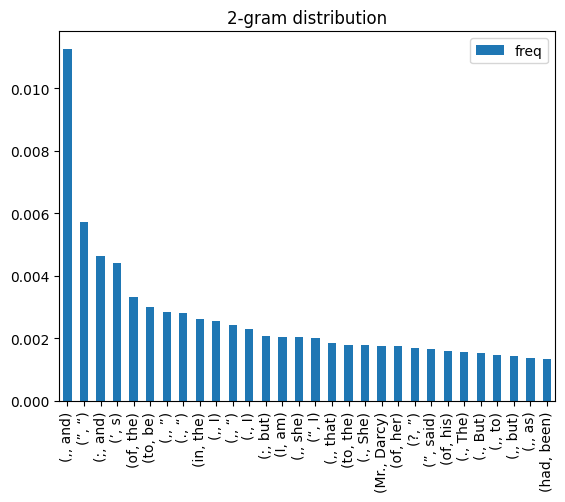

In [68]:
ng = 2
model = fit_ngram_model(corpus, ng)

# Print the trigram probabilities
max_items = 30

pd.DataFrame.from_dict(model, orient='index')\
    .rename(columns={0 : 'freq'})\
    .sort_values(by='freq', ascending=False)\
    .head(max_items)\
    .plot(kind='bar')
plt.title(f'{ng}-gram distribution')
plt.show()


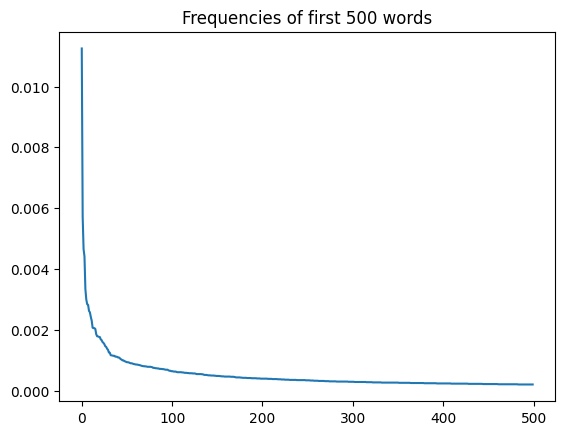

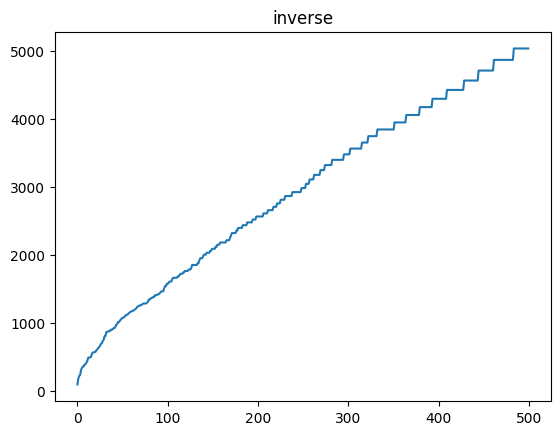

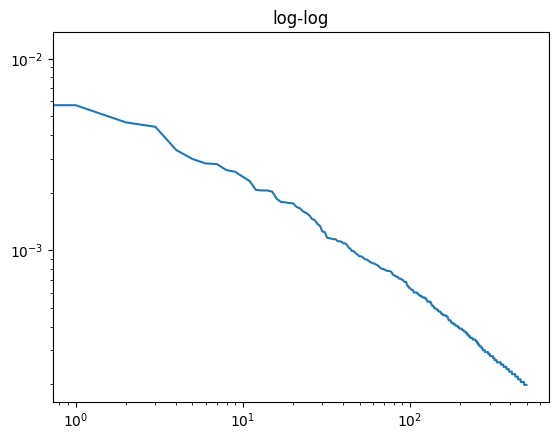

In [69]:
n = 500

freqs = np.sort(np.array(list(model.values())))[::-1]

plt.title(f"Frequencies of first {n} words")
plt.plot(freqs[:n])
plt.show()

plt.title("inverse")
plt.plot(1 / freqs[:n])
plt.show()

plt.title("log-log")
plt.loglog(freqs[:n])
plt.show()

Illustrating "Zipf law" $f_i \propto 1/i$ for uniframs. Zipf "law" is a phenomena discovered by American linguist George Kingsley Zipf
https://en.wikipedia.org/wiki/George_Kingsley_Zipf

The Zipf phenomena only occurs in the most frequent words, after which the tail become thiner than $1/i$ (converges to zero faster) 

In [70]:
sampled_text = sample_from_ngram_model(model, 100)
from pprint import pprint

print("Sample from the model:")
pprint(sampled_text)

Sample from the model:
('sense of glad child charms , to will to ” This up awkward to that opposite '
 'Miss True a vexations gone Forster to Elizabeth fear Her suppose might '
 'Eliza. , . imagine pleased be and He year myself for , struggling not this '
 'beauty , she till it its and not them first , can was when what Bennet at Do '
 'make My came a to on in no . the her , on love seeing temper certain the '
 'herself , that and recall , of convinced , with are sent replied tell '
 'unhappy assured as , three this that')


# Sentence probability


In [75]:
from nltk.lm import MLE, StupidBackoff
from nltk.lm.preprocessing import pad_both_ends
from nltk.lm.preprocessing import flatten
from nltk.lm.preprocessing import padded_everygram_pipeline

def tokenize_sentence(sentence):
    return list(map(str.lower, nltk.word_tokenize(sentence)))

def build_ngran_lm(sentences, ng):
    tokenized_text = [tokenize_sentence(sent) for sent in sentences]
    train_data, padded_sents = padded_everygram_pipeline(ng, tokenized_text)

    lm = MLE(ng) # this is MLE with stupid backoff
    lm.fit(train_data, padded_sents)
    return lm

In [76]:
# break the text into sentences
import nltk
nltk.download('punkt')

def to_sentences(text):
    return nltk.sent_tokenize(text)

sentences = to_sentences(corpus)
print("Size of corpus: ", len(sentences), "sentences")
lm = build_ngran_lm(sentences, 3)
print(lm.vocab.lookup('language is never random .'.split()))

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1007)>


Size of corpus:  4775 sentences
('language', 'is', 'never', '<UNK>', '.')


Counting Unigrams:

In [77]:
unigram_cnts = dict(zip(lm.vocab, [lm.counts[w] for w in lm.vocab]))

Text(0.5, 1.0, 'Unigram Counts')

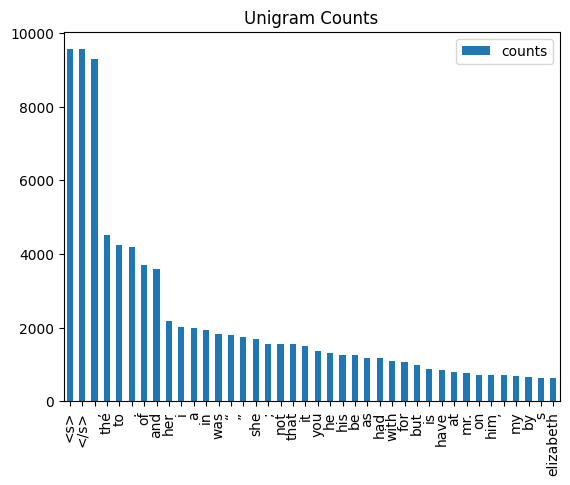

In [78]:
pd.DataFrame.from_dict(unigram_cnts, orient='index')\
    .rename(columns={0 : 'counts'})\
    .sort_values(by='counts', ascending=False)\
    .head(40)\
    .plot.bar()
plt.title("Unigram Counts")

Context (conditional) counter:

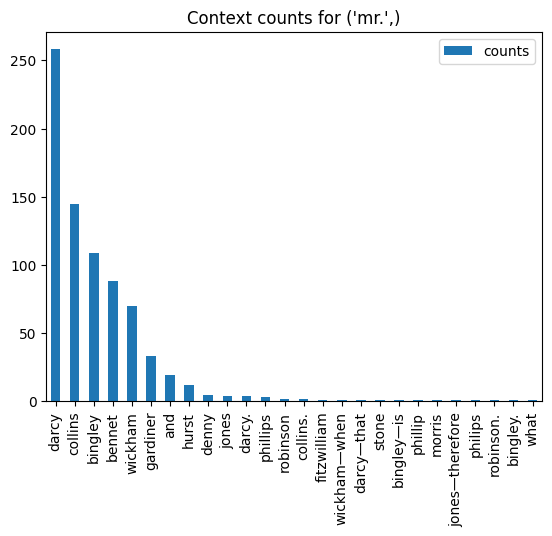

In [82]:
context = ('mr.',)
cnts = lm.context_counts(context)
pd.DataFrame.from_dict(cnts, orient='index')\
    .rename(columns={0 : 'counts'})\
    .sort_values(by='counts', ascending=False)\
    .head(40)\
    .plot.bar()
plt.title(f"Context counts for {context}")
plt.show()

### Sample from the model:

In [83]:
def sampe_from_lm(lm, n_sentences):    
    for _ in range(n_sentences):
        generated_tokens = lm.generate(20)
        # remove </s> and <s>:
        generated_tokens = [t for t in generated_tokens if t not in ['<s>', '</s>']]
        pprint(" ".join(generated_tokens))

sampe_from_lm(lm, 5)

('him from london , before i left hunsford—between our pools at quadrille , '
 'while mrs. jenkinson was chiefly employed in')
('sisters out , miss bennet , and they conversed with so little _endeavour_ at '
 'civility , of her promise concerning')
'meet .'
('proud and repulsive as were not immediately determine what to say , '
 'three—very silly sisters .')
('part of the entrance hall , till the afternoon , when he saw only the '
 'morning , about a year')


In [84]:
list_of_text_ngrams = list(ngrams("all in as much pain".split(), ng))
lm.entropy(list_of_text_ngrams)

inf

Additional material on transformers: 
- "You changed the world" https://blogs.nvidia.com/blog/gtc-2024-transformer-ai-research-panel-jensen/
- https://scholar.harvard.edu/binxuw/classes/machine-learning-scratch/materials/transformers
- https://www.youtube.com/watch?v=kCc8FmEb1nY
